In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath

# Part I: Getting familiar with complex exponential signals

In [ ]:
# Class to generate complex exponential signals with given N and k.
class ComplexExp(object):
   def __init__(self, k, N):
        self.k = k
        self.N = N

        self.n = np.arange(N)

        # Vector containing elements of the complex exponential
        self.exp_kN = np.exp(2j*cmath.pi*self.k*self.n / self.N)
        self.exp_kN *= 1 / (np.sqrt(N))

        # Real and imaginary parts
        self.exp_kN_real = self.exp_kN.real
        self.exp_kN_imag = self.exp_kN.imag

### Using ComplexExp class to generate complex exponential signals of the form $e^{j 2\pi nk/N}$


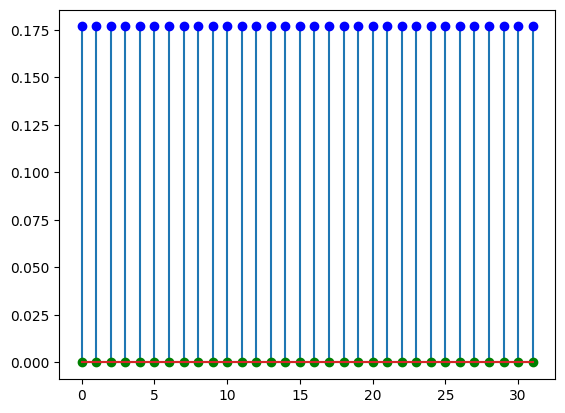

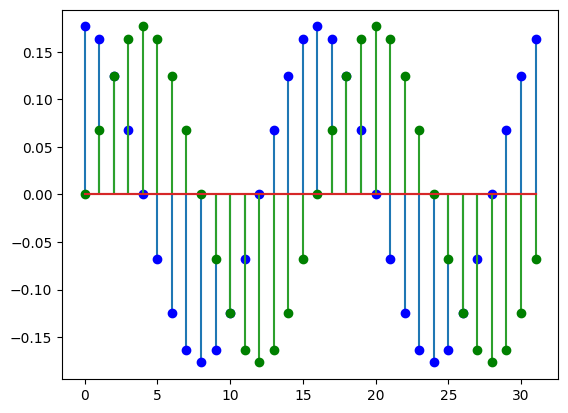

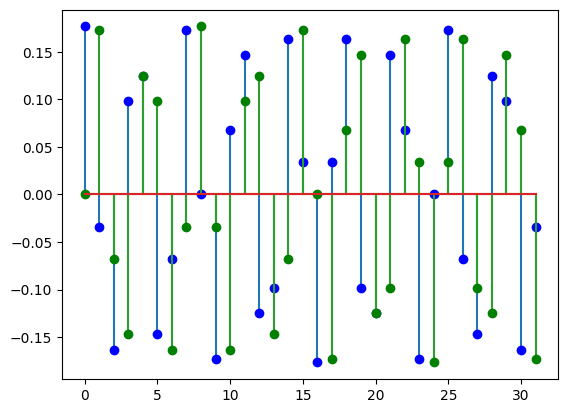

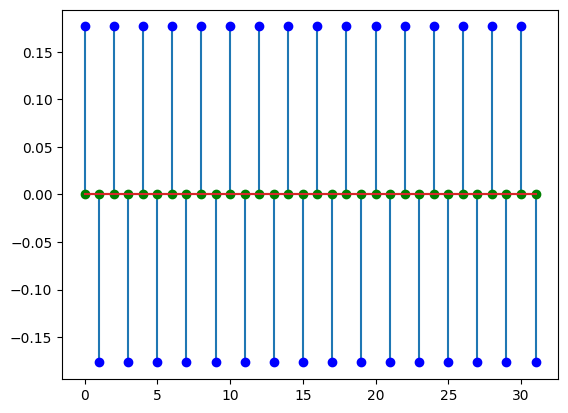

In [ ]:
#Examples of various complex exponential signals with N = 32 and different k

def complex_exp_gen(N, k_list):

    for k in k_list:
        # Creates complex exponential signal with k and N
        exp_k = ComplexExp(k, N)
        # Real and imaginary parts
        cpx_cos = exp_k.exp_kN_real
        cpx_sin = exp_k.exp_kN_imag
        # Plots real and imaginary parts
        cpx_plt = plt.figure()
        plt.stem(exp_k.n, cpx_cos, 'tab:blue', markerfmt='bo')
        plt.stem(exp_k.n, cpx_sin, 'tab:green', markerfmt='go')



if __name__ == '__main__':
    list_of_ks = [0, 2, 9, 16]
    duration_of_signal = 32
    complex_exp_gen(duration_of_signal, list_of_ks)

## CQ1: Use ComplexExp class to verify using figures that the complex exponential signal has period N for N = 8 and N = 16. 

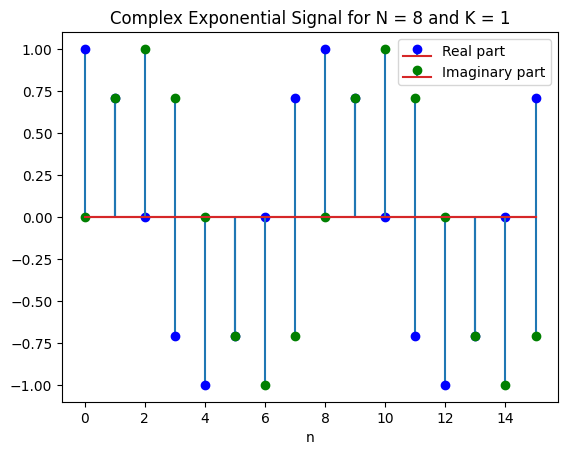

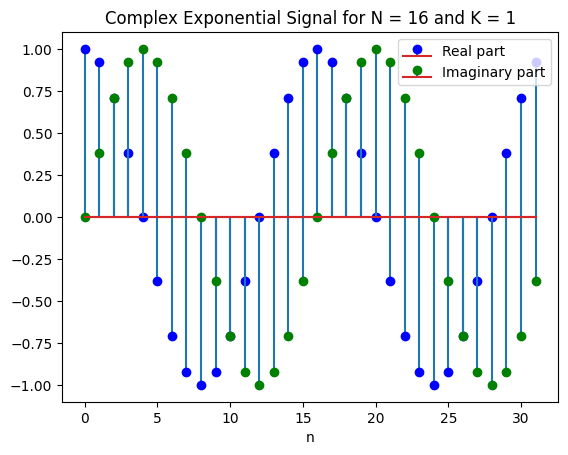

In [ ]:
def verifyPeroid(N,K):
    n = np.arange(2*N)
    x = np.exp(2j * np.pi * K * n / N)
    
    plt.figure()
    plt.stem(n,x.real,markerfmt='bo',label='Real part')
    plt.stem(n,x.imag,markerfmt='go',label='Imaginary part')
    plt.title(f'Complex Exponential Signal for N = {N} and K = {K}')
    plt.xlabel('n')
    plt.legend()
    plt.show()
verifyPeroid(8,1)
verifyPeroid(16,1)
    

In [ ]:
# Function to generate a digital complex exponential signal of duration T, sampling frequency f_s and k = N * f/f_s

def cexpt(f, T, fs):

    N = math.floor(T * fs)
    k = N * f / fs
    # Complex exponential
    cpx_exp = ComplexExp(k, N)
    x = cpx_exp.exp_kN
    x = np.sqrt(N) * x
    return cpx_exp, N


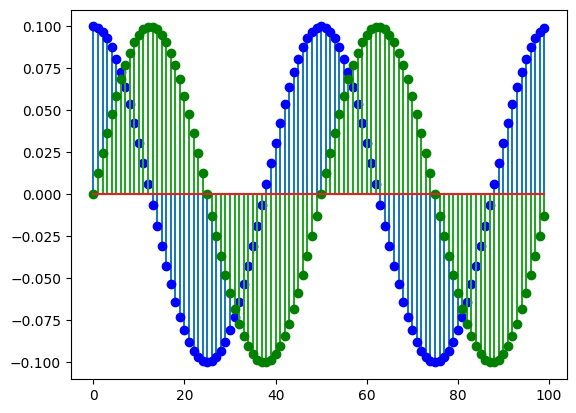

In [ ]:
# The code below will plot complex exponential signal 

from scipy.io.wavfile import write

if __name__ == '__main__':
    f0 = 1
    T = 2
    fs = 50
    cpxexp, num_samples = cexpt(f0, T, fs)
    cpx_cos = cpxexp.exp_kN_real
    cpx_sin = cpxexp.exp_kN_imag
    # Plots real and imaginary parts
    cpx_plt = plt.figure()
    plt.stem(cpxexp.n[0:100], cpx_cos[0:100], 'tab:blue', markerfmt='bo')
    plt.stem(cpxexp.n[0:100], cpx_sin[0:100], 'tab:green', markerfmt='go')

## CQ2: Use the code above to generate signals with f0 = 2, f0 = 3, f0 = 4 and f0 = 5, with sampling frequency fs = 50 and T = 2. Describe the differences between them. 

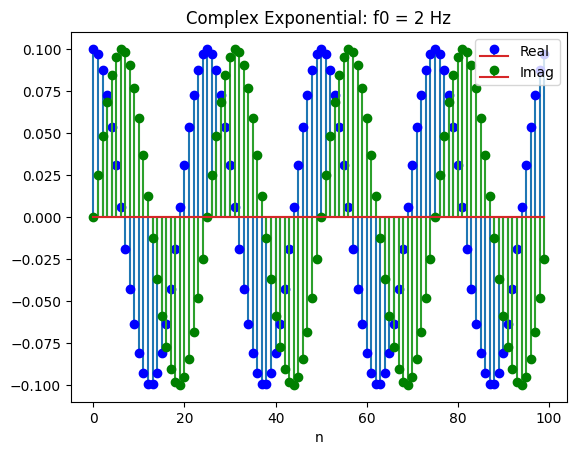

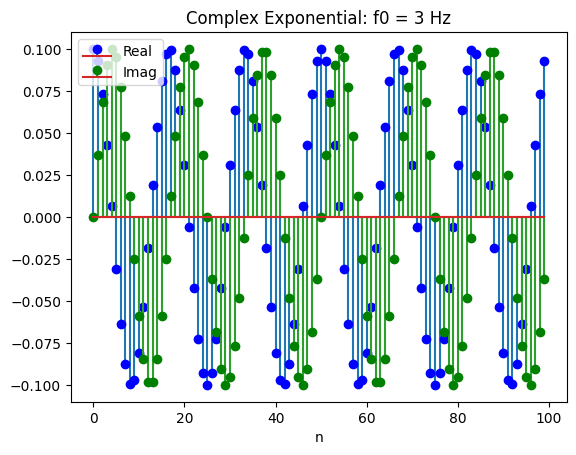

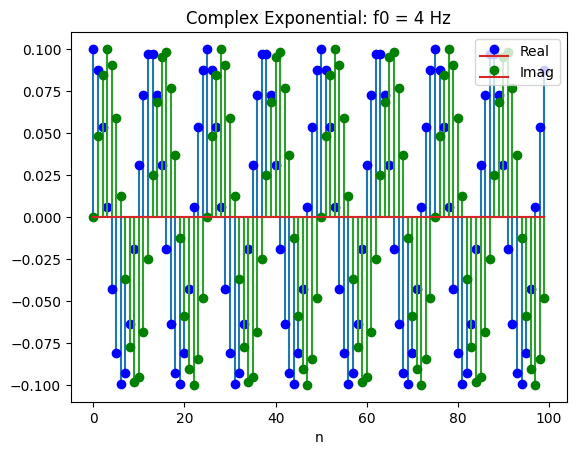

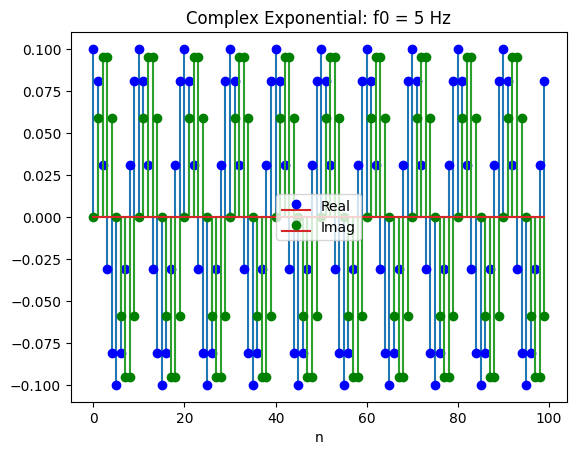

In [ ]:
if __name__ == "__main__":
    T = 2
    fs = 50
    
    for f0 in [2, 3, 4, 5]:
        cpxexp, num_samples = cexpt(f0, T, fs)
        
        plt.figure()
        plt.stem(cpxexp.n, cpxexp.exp_kN_real, 'tab:blue', markerfmt='bo', label='Real')
        plt.stem(cpxexp.n, cpxexp.exp_kN_imag, 'tab:green', markerfmt='go', label='Imag')
        
        plt.title(f'Complex Exponential: f0 = {f0} Hz')
        plt.xlabel('n')
        plt.legend()
        plt.show()

#we see that when we keep increasing the frequency, the signal oscillates faster.Higher frequenceis complete more cycles then lower frequencies.

# Part 2: Digital signals and DFT

In [ ]:
# Classes of different digital signals: square pulse and a triangular pulse

class sqpulse(object):
    """
    Creates a discrete square pulse signal of width M, with signal length N.
    Arguments:
        T0: width of square pulse (int)
        T: duration of the signal (int)
        fs: sampling frequncy (int)
    """
    def __init__(self, T0, T, fs):
        self.N=int(np.floor(T*fs))
        self.M=int(np.floor(T0*fs))
        # Create the square pulse of width M
        self.pulse=np.concatenate((np.ones(self.M),np.zeros(self.N-self.M)))
        self.pulse*=1/np.sqrt(self.M)

        # Create the time array
        self.t=np.arange(0,T,1/fs)


class tripulse(object):
    """
    tripulse Generates a unit-energy triangular pulse
 	tripulse(T0,T,fs) generates a unit-energy triangular pulse x(t) of 
 	duration T sampled at frequency fs and with active duration T0.
 	Vector t contains the time indices (x axis) and vector x contains
 	the values of the signal (y axis).
    Arguments:
        T0: width of triangular pulse (int)
        T: duration of the signal (int)
        fs: sampling frequncy (int)
 	See also sqpulse.
    """
    def __init__(self, T0, T, fs):
        self.N=int(np.floor(T*fs))
        self.M=int(np.floor(T0*fs))

        # Create the active part
        ascendent_part = np.arange(0,np.ceil(T0/2*fs))
        descendent_part = np.arange(np.ceil(T0/2*fs)-1,0,-1)

        # Construct the triangular pulse
        self.pulse=np.concatenate((ascendent_part,descendent_part,np.zeros(self.N-len(ascendent_part)-len(descendent_part))))

        # Normalize
        self.pulse*=1/np.linalg.norm(self.pulse)

        # Create the time array
        self.t=np.arange(0,T,1/fs)



In [ ]:
# Class to calculate DFT of a digital signal


class dft():
    def __init__(self, x, fs, K=None):
        """
        :param x: Input vector x contains the discrete signal
        :param fs: Input integer fs contains the sample frequency
        :param K: Input positive integer that determines the number of coeffients
        used to calculate the DFT. If K is not provided, K=length(x).
        """
    # START: SANITY CHECK OF INPUTS.
        if (type(fs) != int) or (fs<=0):
            raise NameError('The frequency fs should be a positive integer.')
        if not isinstance(x, np. ndarray):
            raise NameError('The input signal x must be a numpy array.')
        if isinstance(x, np. ndarray):
            if x.ndim!=1:
                raise NameError('The input signal x must be a numpy vector array.')
        self.x=x
        self.fs=fs
        self.N=len(x)
        if K == None:
            K = len(self.x)
        # START: SANITY CHECK OF INPUTS.
        if (type(K) != int) or (K <= 0) or (K < 0):
            raise NameError('K should be a positive integer.')
        self.K=K
        self.f=np.arange(self.K)*self.fs/self.K # (0:K-1) just creates a vector from 0 to K by steps of 1.
        self.f_c=np.arange(-np.ceil(K/2)+1,np.floor(self.K/2)+1)*self.fs/self.K
        # This accounts for the frequencies
        # centered at zero. I want to be guaranteed that k=0 is always a
        # possible k. Then, I also have to account for both even and odd choices
        # of K, and that's why the floor() function appears to round down the
        # numbers.

    def dft_fn(self):
            """
            METHOD: Built-in fft() function
            """
            X=np.fft.fft(self.x,self.K)/np.sqrt(self.N);
            # \\\\\ CENTER FFT.
            X_c=np.roll(X,int(np.ceil(self.K/2-1))) # Circularly shift X to get it centered in f_c==0
            return [self.f,X,self.f_c,X_c]

In [ ]:
# Function to calculate energy of a signal
def energy(f, X,  interval):
    """
    energy computes the energy of a signal in a frequency interval
    X: DFT of signal (array)
    f: frequency array of signal DFT
    interval: Frequency interval (list of len()=2 of int), interval[0]=<interval[1]
    :return: Energy of signal in interval (float)
    """
    aux=0
    for i,freq in enumerate(f):
        if freq>=interval[0] and freq<=interval[1]:
            aux=aux+abs(X[i]*np.conjugate(X[i]))

    return aux

In [ ]:
# Function to plot square pulse and its DFT

def plot_pulse_and_dft(T, fs, T0s):
    """
    DFT of a pulse
    Arguments:
        T: duration of the signal (int)
        fs: sampling frequency (int)
        T0s: square_pulses_lengths (list of ints)
    """
    for T0 in T0s:

        # Obtain the signal
        sqpulse_signal =  sqpulse(T0, T, fs)

        # Obtain the DFT
        sqpulse_dft = dft(sqpulse_signal.pulse, fs)
        [freqs,X,f_c,X_c]=dft.dft_fn(sqpulse_dft)

        # Compute the enegy in interval
        Total_ener=np.sum(abs(X_c)**2)
        Partial_ener = abs(energy(f_c, X_c, [-1 / T0, 1 / T0]))
        print('Energy fraction of a square pulse of T0=%3.2f is %5.4f'%(T0, Partial_ener/Total_ener))

        # Plot
        fig, axs = plt.subplots(2)
        axs[0].grid()
        axs[1].grid()
        fig.suptitle('Square Pulse of Width %3.2fs '%(T0))
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
        axs[0].plot(sqpulse_signal.t, sqpulse_signal.pulse)
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('Signal')
        axs[1].plot(f_c,abs(X_c))
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('DFT')
        plt.savefig('square_pulse_'+str(T0)+'.png')
        plt.show()

Energy fraction of a square pulse of T0=0.10 is 0.9062


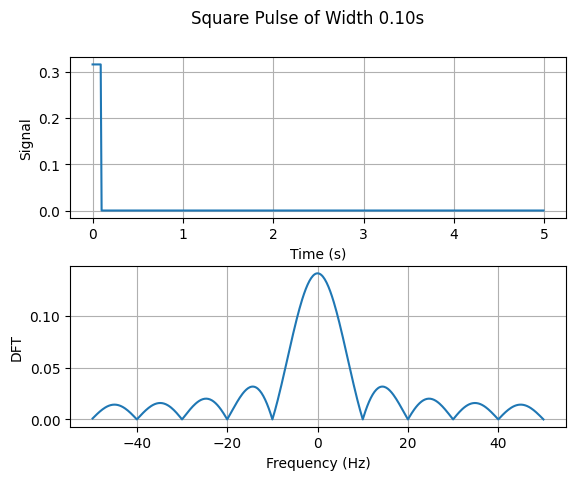

Energy fraction of a square pulse of T0=0.20 is 0.9037


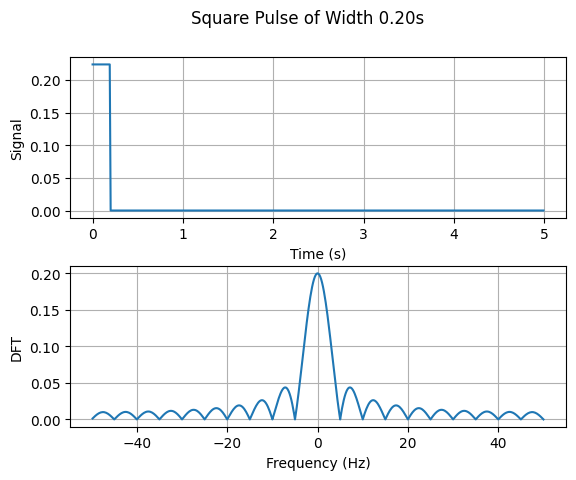

Energy fraction of a square pulse of T0=0.50 is 0.9030


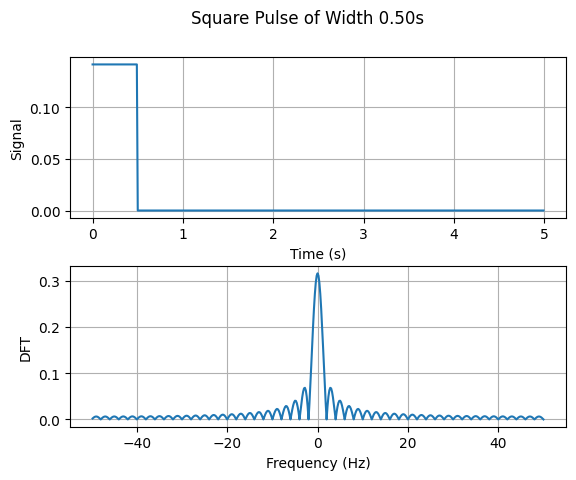

In [ ]:
plot_pulse_and_dft(5, 100, [0.1,0.2,0.5])

## CQ3: The above code shows an example of generating a square pulse and its DFT for different pulse widths. Adapt the above code to generate a triangular pulse and its DFT (show figures) for T = 3, fs = 50, and pulse durations T0s = [0.1,0.2,0.3]. Summarize your findings.

In [ ]:
def plot_pulse_and_dft(T, fs, T0s):
    """
    DFT of a pulse
    Arguments:
        T: duration of the signal (int)
        fs: sampling frequency (int)
        T0s: square_pulses_lengths (list of ints)
    """
    for T0 in T0s:

        # Obtain the signal
        tpulse_signal =  tripulse(T0, T, fs)

        # Obtain the DFT
        #sqpulse_dft = dft(sqpulse_signal.pulse, fs)
        tpulse_dft = dft(tpulse_signal.pulse, fs)
        
        #[freqs,X,f_c,X_c]=dft.dft_fn(sqpulse_dft)
        [freqs,X,f_c,X_c] = dft.dft_fn(tpulse_dft)
        

        # Compute the enegy in interval
        Total_ener=np.sum(abs(X_c)**2)
        Partial_ener = abs(energy(f_c, X_c, [-1 / T0, 1 / T0]))
        print('Energy fraction of a triangle pulse of T0=%3.2f is %5.4f'%(T0, Partial_ener/Total_ener))

        # Plot
        fig, axs = plt.subplots(2)
        axs[0].grid()
        axs[1].grid()
        fig.suptitle('Triangel Pulse of Width %3.2fs '%(T0))
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
        axs[0].plot(tpulse_signal.t, tpulse_signal.pulse)
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('Signal')
        axs[1].plot(f_c,abs(X_c))
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('DFT')
        plt.savefig('square_pulse_'+str(T0)+'.png')
        plt.show()

Energy fraction of a triangle pulse of T0=0.10 is 0.9512


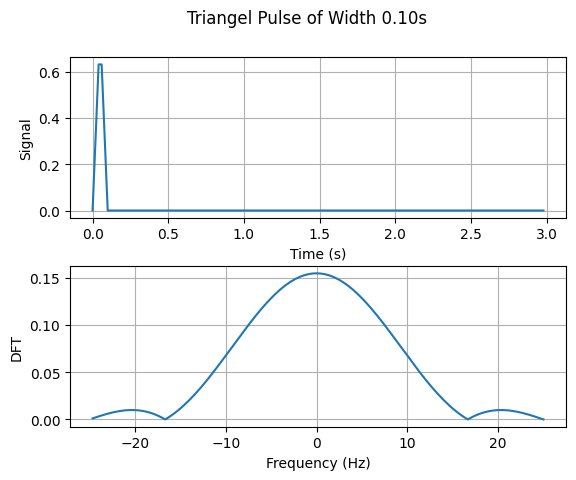

Energy fraction of a triangle pulse of T0=0.20 is 0.9286


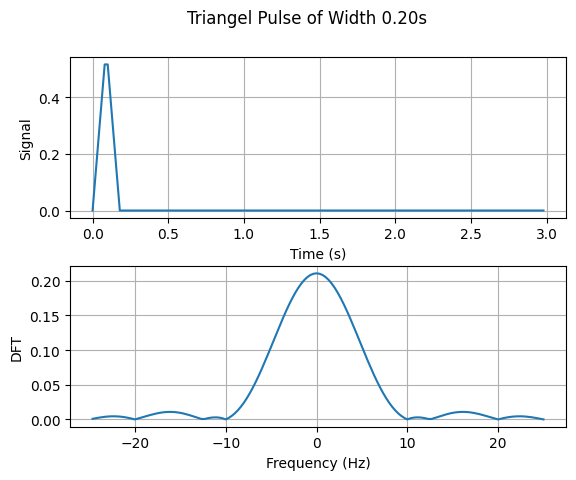

Energy fraction of a triangle pulse of T0=0.30 is 0.9611


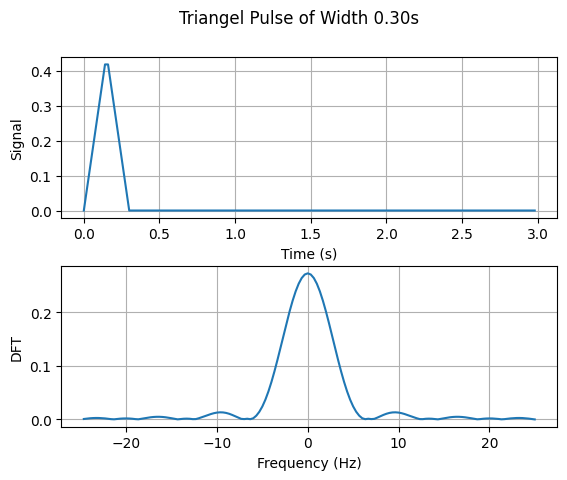

In [ ]:
plot_pulse_and_dft(3,50,[0.1,0.2,0.3])

# Part 3. Reconstructing a signal from DFT

In [ ]:
class idft():
    """
    idft Inverse Discrete Fourier transform.
    """
    def __init__(self, X, fs, N, K=None):
        """
        :param X: Input DFT X
        :param fs: Input integer fs contains the sample frequency
        :param N: The number of total signal samples N
        :param K: Input positive integer that determines the number of coeffients
        used to calculate the iDFT.
        """
        self.X=X
        self.fs=fs
        self.N=N 
        self.K=K
        if self.K==None:
            self.K=int(len(X)/2)-1

    def solve_K(self):
        """
        \\\\\ METHOD: Compute the iDFT with truncated K coefficients (Due to computation complexity, we will not use it in Section 2)
        :return iDFT x of duration N from partial DFT X, i.e., X[0], ..., X[K] with K < N/2
        :Treal the realt time vector of size N
        """
        x=np.zeros(self.N)
        
        for n in range(self.N):
            x[n] = 1/np.sqrt(self.N)*self.X[0]*np.exp(1j*2*cmath.pi*0*n/self.N)
            for k in range(1,self.K+1): 
                x[n] = x[n] + 1/np.sqrt(self.N)*self.X[k]*np.exp(1j*2*cmath.pi*k*n/self.N)
                x[n] = x[n] + 1/np.sqrt(self.N)*np.conj(self.X[k])*np.exp(-1j*2*cmath.pi*k*n/self.N)
                
        Ts= 1/self.fs
        Treal= np.arange(self.N)*Ts

        return x, Treal
    
    def solve_ifft(self):
        """
        \\\\\ METHOD: Compute the iDFT with provided function np.fft.ifft (Computationally efficient)
        :Treal the realt time vector of size N
        """
        x=np.fft.ifft(self.X,self.N)*np.sqrt(self.N)
                
        Ts= 1/self.fs
        Treal= np.arange(self.N)*Ts

        return x, Treal    


<>:21: SyntaxWarning: invalid escape sequence '\ '
<>:40: SyntaxWarning: invalid escape sequence '\ '
<>:21: SyntaxWarning: invalid escape sequence '\ '
<>:40: SyntaxWarning: invalid escape sequence '\ '
/var/folders/hb/93rb0mhn4dj_q8_3xlwc57pw0000gn/T/ipykernel_3853/1560866097.py:21: SyntaxWarning: invalid escape sequence '\ '
  """
/var/folders/hb/93rb0mhn4dj_q8_3xlwc57pw0000gn/T/ipykernel_3853/1560866097.py:40: SyntaxWarning: invalid escape sequence '\ '
  """


In [ ]:
# The code below provides an example of reconstructing a square pulse with K DFT coefficients.

class sqpulse():
    """
    sqpulse Generates a square spulse
    solve() generates a square pulse vector x of length N
    """
    def __init__(self, T, T0, fs):
        """
        :param T: the duration
        :param T0: nonzero length
        :param fs: the sampling frequency
        """
        self.T = T
        self.T0 = T0
        self.fs = fs
                
    def solve(self):
        """
        :return: [x,N]
        :x: the square pulse vector x
        :N: The sample duration
        """
        Ts = 1/self.fs
        N = math.floor(self.T/Ts)
        M = math.floor(self.T0/Ts)
        x = np.zeros(N)
        
        for i in range(M):
            x[i] = 1/np.sqrt(M)
        
        return x, N


def signal_DFT_and_reconstruction(T, fs, T0, K):
    sp = sqpulse(T, T0, fs)    #generate square pulse signal
    x, N = sp.solve()
    DFT = dft(x,fs)      #compute the DFT
    [f,X,f_c,X_c] = dft.dft_fn(DFT)
    
    iDFT = idft(X, fs, N, K)      #compute the iDFT with K coefficients
    xhat_K, Treal = iDFT.solve_K()
    
    x_diff = x - xhat_K    #compute the energe difference
    energy_diff = np.linalg.norm(x_diff)*np.linalg.norm(x_diff)   
    print(energy_diff)
    
    # Plot
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Signal and its DFT' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(f_c, abs(X_c))
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('DFT')
    plt.show()    
    fig.savefig("square_DFT.png", bbox_inches='tight')
    
    plt.figure()
    plt.grid(True)
    plt.title('Reconstructed Signal')
    plt.plot(Treal, xhat_K)
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.savefig('Square_reconstructed.png')
    plt.show()
#    

0.1884634852965931


/var/folders/hb/93rb0mhn4dj_q8_3xlwc57pw0000gn/T/ipykernel_3853/1560866097.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = 1/np.sqrt(self.N)*self.X[0]*np.exp(1j*2*cmath.pi*0*n/self.N)
/var/folders/hb/93rb0mhn4dj_q8_3xlwc57pw0000gn/T/ipykernel_3853/1560866097.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = x[n] + 1/np.sqrt(self.N)*self.X[k]*np.exp(1j*2*cmath.pi*k*n/self.N)
/var/folders/hb/93rb0mhn4dj_q8_3xlwc57pw0000gn/T/ipykernel_3853/1560866097.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = x[n] + 1/np.sqrt(self.N)*np.conj(self.X[k])*np.exp(-1j*2*cmath.pi*k*n/self.N)


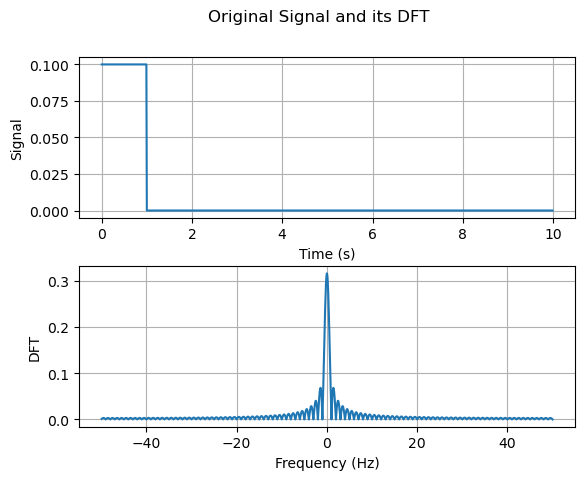

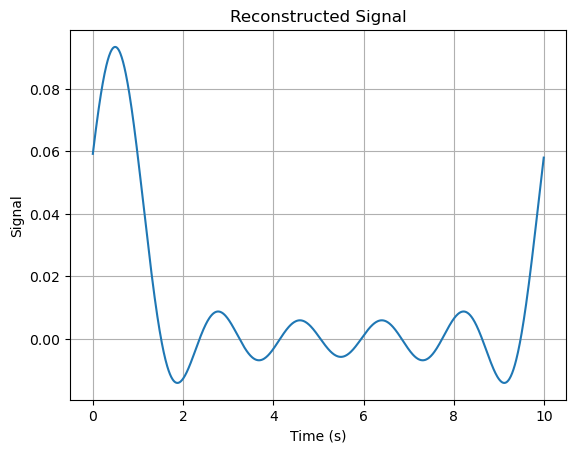

In [ ]:
signal_DFT_and_reconstruction(10, 100, 1, 5)

## CQ4: Adapt the code above to reconstruct a triangular pulse (T = 10, fs = 100, T0 = 1) with K = 5, 10, 25, and 50 coefficients. Use the tripulse class below for generating a triangular pulse. Summarize your findings with figures and text descriptions.

In [ ]:
class tripulse():
    """
    sqpulse Generates a triangular spulse
    solve() generates a triangular pulse vector x of length N
    """
    def __init__(self, T, T0, fs):
        """
        :param T: the duration
        :param T0: nonzero length
        :param fs: the sampling frequency
        """
        self.T = T
        self.T0 = T0
        self.fs = fs

    def solve(self):
        """
        :return: [x,N]
        :x: the triangular pulse vector x
        :N: The sample duration
        """
        Ts = 1/self.fs
        N = math.floor(self.T/Ts)
        M = math.floor(self.T0/Ts)
        x = np.zeros(N)
        
        for i in range(int(M/2)):
            x[i] = i
            x[M-i-1] = i
            
        energy = np.linalg.norm(x)
            
        for i in range(M):
            x[i] = x[i]/energy        
        
        return x, N
    def signal_DFT_and_reconstruction(T, fs, T0, K):
        tp = tripulse(T, T0, fs)    #generate square pulse signal
        x, N = tp.solve()
        DFT = dft(x,fs)      #compute the DFT
        [f,X,f_c,X_c] = dft.dft_fn(DFT)
        
        iDFT = idft(X, fs, N, K)      #compute the iDFT with K coefficients
        xhat_K, Treal = iDFT.solve_K()
        
        x_diff = x - xhat_K    #compute the energe difference
        energy_diff = np.linalg.norm(x_diff)*np.linalg.norm(x_diff)   
        print(energy_diff)
        
        # Plot
        fig, axs = plt.subplots(2)
        axs[0].grid()
        axs[1].grid()
        fig.suptitle('Original Signal and its DFT' )
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
        axs[0].plot(Treal, x)
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('Signal')
        axs[1].plot(f_c, abs(X_c))
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('DFT')
        plt.show()    
        fig.savefig("triangle_DFT.png", bbox_inches='tight')
        
        plt.figure()
        plt.grid(True)
        plt.title('Reconstructed Signal')
        plt.plot(Treal, xhat_K)
        plt.xlabel('Time (s)')
        plt.ylabel('Signal')
        plt.savefig('Triangle_reconstructed.png')
        plt.show()

In [ ]:
signal_DFT_and_reconstruction(10,100,1,5)